In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from fns import *
from syntheticdata import synthetic_generation

In [2]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,nz,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers: {layers}, FeaturesRoot: {features_root}, ConvolutionSize: {filter_size}*{filter_size}*{filter_size}, PoolingSize: {pool_size}*{pool_size}*{pool_size}"\
                 .format(layers=layers, features_root=features_root, filter_size=filter_size, pool_size=pool_size))
    
    in_node = x
    batch_size = tf.shape(x)[0] 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    in_size = 144
    size = in_size

   
    # down layers
    with tf.name_scope('going_down'):
        for layer in range(0, layers):
            with tf.name_scope('layer_down_%d'%layer):
                features = 2**layer*features_root
                stddev = 1 / (filter_size**3 * features)
                if layer == 0:
                    w1 = weight_variable([filter_size, filter_size, filter_size, channels, features], stddev)
                else:
                    w1 = weight_variable([filter_size, filter_size, filter_size, features//2, features], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features, features], stddev)
                b1 = bias_variable([features])
                b2 = bias_variable([features])
                
                conv1 = conv3d(in_node, w1, keep_prob)
                tmp_h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(tmp_h_conv, w2, keep_prob)
                dw_h_convs[layer] = tf.nn.elu(conv2 + b2)
                
                logging.info("Down Convoltion Layer: {layer} Size: {size}".format(layer=layer,size=dw_h_convs[layer].get_shape()))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size -= 4    
                if layer < layers-1:
                    pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                    in_node = pools[layer]
                    size /= 2    
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    with tf.name_scope('going_up'):
        for layer in range(layers-2, -1, -1):   
            with tf.name_scope('layer_up_%d'%layer):
                features = 2**(layer+1)*features_root
                stddev = 1 / (filter_size**3 * features)

                wd = weight_variable_devonc([pool_size, pool_size, pool_size, features//2, features], stddev)
                bd = bias_variable([features//2])
                h_deconv = tf.nn.elu(deconv3d(in_node, wd, pool_size) + bd)
                h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)    
                deconv[layer] = h_deconv_concat

                w1 = weight_variable([filter_size, filter_size, filter_size, features, features//2], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features//2, features//2], stddev)
                b1 = bias_variable([features//2])
                b2 = bias_variable([features//2])

                conv1 = conv3d(h_deconv_concat, w1, keep_prob)
                h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(h_conv, w2, keep_prob)
                in_node = tf.nn.elu(conv2 + b2)
                up_h_convs[layer] = in_node
                
                logging.info("Up Convoltion Layer: {layer} Size: {size}".format(layer=layer,
                                                                                size=tf.shape(dw_h_convs[layer])))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size *= 2
                size -= 4

    # Output Map
    with tf.name_scope('output_map'):
        #stddev = 1 / (features_root)
        weight = weight_variable([1, 1, 1, features_root, 1], stddev)
        bias = bias_variable([1])
        conv = conv3d(in_node, weight, tf.constant(1.0))
        output_map = tf.nn.sigmoid(conv + bias)
        up_h_convs["out"] = output_map
        logging.info("Output map shape {size}, offset {offset}".format(size=output_map.get_shape(), offset=int(in_size-size)))

        if summaries:
#             for i, (c1, c2) in enumerate(convs):
#                 tf.summary.image('summary_conv_%03d_01'%i, get_image_summary(c1))
#                 tf.summary.image('summary_conv_%03d_02'%i, get_image_summary(c2))

#             for k in pools.keys():
#                 tf.summary.image('summary_pool_%03d'%k, get_image_summary(pools[k]))

#             for k in deconv.keys():
#                 tf.summary.image('summary_deconv_concat_%03d'%k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%03d"%k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])

        variables = []
        for w1,w2 in weights:
            variables.append(w1)
            variables.append(w2)

        for b1,b2 in biases:
            variables.append(b1)
            variables.append(b2)
        
        variables.append(weight)
        variables.append(bias)
        
    return output_map, variables, int(in_size - size)

In [3]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=1, n_class=1, cost="dice_coefficient", predict_thresh=0.5, cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder(tf.float32, shape=[None, None, None, None, channels], name='data')
        self.y = tf.placeholder(tf.float32, shape=[None, None, None, None, n_class], name='target')
        self.keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)
        logging.info("Actual Output Shape: {}".format(logits.get_shape()))
        logging.info("Desired Output Shape: {}".format(self.y.get_shape()))

        self.logits = logits
        self.predicter = self.logits
        self.predicter_label = tf.cast(self.predicter >= predict_thresh, tf.float32)
        self.correct_pred = tf.cast(
            tf.equal(tf.reshape(self.predicter_label, [-1, n_class]), tf.reshape(self.y, [-1, n_class])), tf.float32)
        self.cost = self._get_cost(self.logits, self.predicter, cost, cost_kwargs)
        self.gradients_node = tf.gradients(self.cost, self.variables)
        self.cross_entropy = tf.reduce_mean(
            cross_entropy(tf.reshape(self.y, [-1, n_class], name='cross_entro_label_reshape'),
                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class], name='px_logit_reshape')))
        self.accuracy = tf.reduce_mean(self.correct_pred)

    def _get_cost(self, logits, predicter, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        with tf.name_scope('cost_function'):
            logging.info('*' * 50)
            logging.info('getting cost')
            logging.info("Logits: {}".format(logits.get_shape()))
            logging.info("Y: {}".format(self.y.get_shape()))
            flat_logits = tf.reshape(logits, [-1, self.n_class], name='flat_logits_reshape')
            flat_predicter = tf.reshape(predicter, [-1, self.n_class], name='flat_predicter_reshape')
            flat_labels = tf.reshape(self.y, [-1, self.n_class], name='flat_labels_reshape')
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights, name='weightmap')
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map, name='weightloss')

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                                                  labels=flat_labels))
            elif cost_name == "dice_coefficient":
                intersection = tf.reduce_sum(flat_predicter * flat_labels)
                union = tf.reduce_sum(flat_predicter) + tf.reduce_sum(flat_labels)
                loss = 1 - 2 * intersection / union

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, nz, channels]
        :returns prediction: The unet prediction Shape [n, px, py, pz, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], self.n_class))
            prediction = sess.run(self.predicter_label, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

## setting up the unet

In [4]:
net = Unet(channels=1, 
           n_class=1, 
           layers=4, 
           pool_size=2,
           features_root=16, summaries=True,
          )

## training

In [6]:
provider = ImageDataProvider(split_vol=True, check_vol=True)
provider.check_vol = True
provider.split_vol = True
provider.thresh = 5000
provider._find_data_files()
count, vals = provider._count_valid_training(provider.training_data_files)

  0%|          | 4/1103 [00:00<00:28, 38.57it/s]

--------------------------------------------------
Using split volumes
Number of training data used: 1103
Number of validation data used: 270
Number of testing data used: 147
--------------------------------------------------
Using split volumes


100%|██████████| 1103/1103 [00:23<00:00, 46.86it/s]


<IPython.core.display.Javascript object>


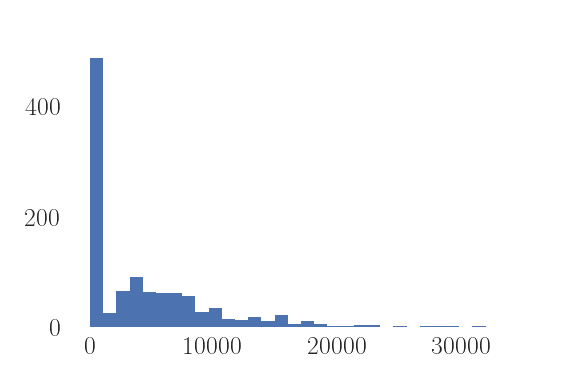

391


In [7]:
plt.hist(vals, 30)
print(count)

In [ ]:
# data_provider = ImageDataProvider(array=False)
data_provider = provider
trainer = Trainer(net, batch_size=3, optimizer="adam")
path = trainer.train(data_provider, 
                     "./unet_trained",
                     training_array = None,
                     validation_array = None,
                     testing_array = None,
                     training_iters=count, 
                     epochs=100, 
                     dropout=0.75, 
                     restore= False,
                     display_step=1)

### Predict

In [7]:
provider = ImageDataProvider()
# testing_data, label_data = provider._load_data_and_label(provider.testing_data_files,3)
testing_data, label_data = provider._load_data_and_label(provider.testing_data_files,2)


Number of training data used: 37
Number of validation data used: 7
Number of testing data used: 3


In [8]:
testing_data.shape

(2, 148, 148, 148, 1)

In [9]:
provider.testing_data_files[:2]

['/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_clahe/028/case.nrrd',
 '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_clahe/051/case.nrrd']

In [10]:
i = 1
prediction = net.predict("./unet_trained/model 15.cpkt", testing_data[i][np.newaxis,...])[0][:,:,:,0]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


In [11]:
print(np.unique(prediction, return_counts=True))
print(prediction.shape)
print(label_data.shape)

(array([ 0.,  1.], dtype=float32), array([212057,   3943]))
(60, 60, 60)
(2, 148, 148, 148, 1)


<IPython.core.display.Javascript object>


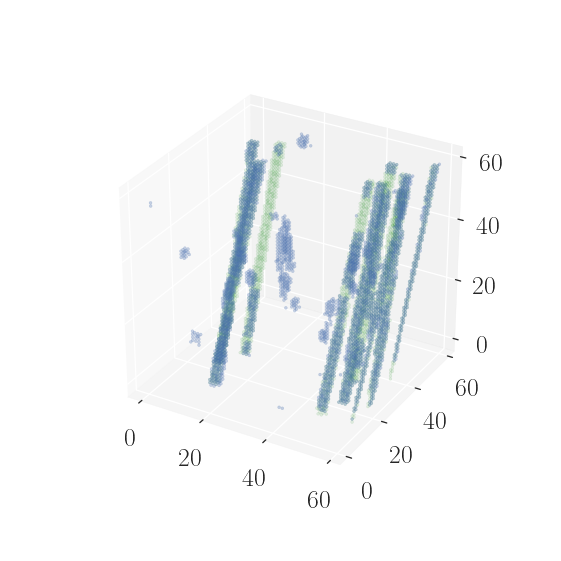

In [12]:
%matplotlib notebook
xs,ys,zs = np.where(prediction == 1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=5)
plt.show()

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = np.where(label_data[i, 44:-44,44:-44,44:-44,0] == 1)
ax.scatter(xs, ys, zs, marker='o',color='g', alpha=0.1, s=5)
plt.show()

<IPython.core.display.Javascript object>


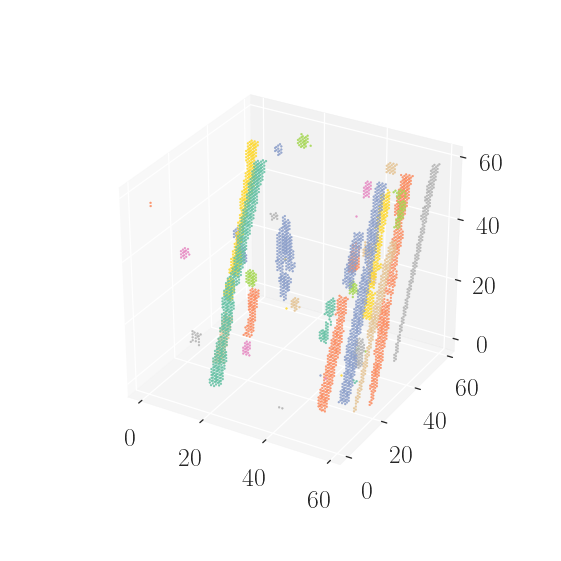

In [13]:
np.random.seed(1)
islands = measure.label(prediction)
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

<IPython.core.display.Javascript object>


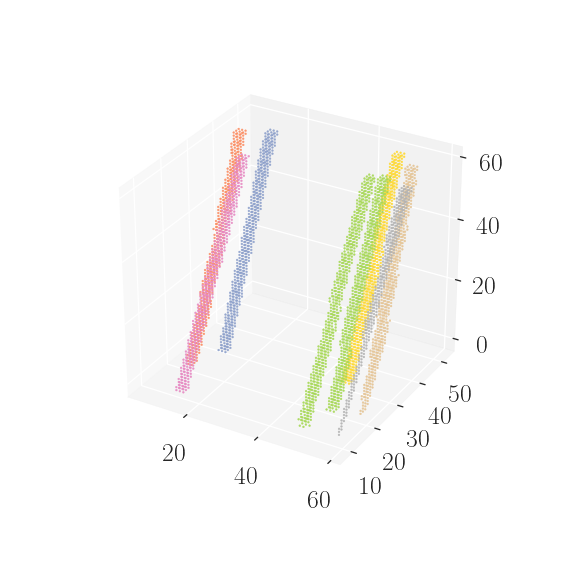

In [14]:
np.random.seed(1)
islands = measure.label(label_data[i,...,0][44:-44,44:-44,44:-44])
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

In [37]:
image_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/051/case.nrrd'
label_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/051/needles.nrrd'
# img = provider._load_file(image_name, np.float32, padding="noise")
label = provider._load_file(label_name, np.bool, padding="zero")

# data = provider._process_data(img)
# label = provider._process_labels(label)

# data, label = provider._post_process(data, label)

# nx = data.shape[0]
# ny = data.shape[1]
# nz = data.shape[2]

# data, label = data.reshape(1, nx, ny, nz, provider.channels), label.reshape(1, nx, ny, nz, provider.n_class)

In [38]:
# print(img.shape)
# print(data.shape)

In [39]:
# data.shape

In [40]:
tiles = (148,148,148)
tile = 148

In [41]:
data, options = nrrd.read(image_name)
data = data.astype(np.float32)
print(data.shape)
d = data.resize(max(data.shape[0],tile),
               max(data.shape[1],tile),
               max(data.shape[2],tile))
print(data.shape)
print(options)

(300, 195, 191)
(300, 195, 191)
{'keyvaluepairs': {}, 'type': 'unsigned short', 'dimension': 3, 'space': 'left-posterior-superior', 'sizes': [300, 195, 191], 'space directions': [['1', '0', '0'], ['0', '1', '0'], ['0', '0', '1']], 'kinds': ['domain', 'domain', 'domain'], 'endian': 'little', 'encoding': 'gzip', 'space origin': ['-157.53155517578125', '-90.830169677734375', '-123.8685989379883']}


## Inference pipeline

In [42]:
arr_data = cutVolume(data)
arr_pred = predict_full_volume(net, arr_data, model_path="./unet_trained/model 15.cpkt")
full_pred = recombine(arr_pred, data)

Original input shape (300, 195, 191)
Padded input shape: (388, 283, 279)
# of parts 7 7 5
number of tiles: 45 


  0%|          | 0/45 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


  2%|▏         | 1/45 [00:01<01:11,  1.62s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


  4%|▍         | 2/45 [00:03<01:09,  1.62s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


  7%|▋         | 3/45 [00:04<01:07,  1.62s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


  9%|▉         | 4/45 [00:06<01:06,  1.62s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 11%|█         | 5/45 [00:08<01:04,  1.62s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 13%|█▎        | 6/45 [00:09<01:03,  1.64s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 16%|█▌        | 7/45 [00:11<01:03,  1.66s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 18%|█▊        | 8/45 [00:13<01:02,  1.68s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 20%|██        | 9/45 [00:14<01:00,  1.68s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 22%|██▏       | 10/45 [00:16<00:59,  1.69s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 24%|██▍       | 11/45 [00:18<00:57,  1.69s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 27%|██▋       | 12/45 [00:20<00:56,  1.71s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 29%|██▉       | 13/45 [00:22<00:57,  1.79s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 31%|███       | 14/45 [00:23<00:55,  1.78s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 33%|███▎      | 15/45 [00:25<00:53,  1.78s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 36%|███▌      | 16/45 [00:27<00:51,  1.78s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 38%|███▊      | 17/45 [00:29<00:50,  1.80s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 40%|████      | 18/45 [00:31<00:49,  1.83s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 42%|████▏     | 19/45 [00:32<00:47,  1.81s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 44%|████▍     | 20/45 [00:34<00:45,  1.82s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 47%|████▋     | 21/45 [00:36<00:43,  1.83s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 49%|████▉     | 22/45 [00:38<00:42,  1.83s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 51%|█████     | 23/45 [00:40<00:40,  1.84s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 53%|█████▎    | 24/45 [00:42<00:38,  1.84s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 56%|█████▌    | 25/45 [00:44<00:37,  1.87s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 58%|█████▊    | 26/45 [00:46<00:36,  1.90s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 60%|██████    | 27/45 [00:47<00:34,  1.92s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 62%|██████▏   | 28/45 [00:49<00:32,  1.93s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 64%|██████▍   | 29/45 [00:51<00:30,  1.91s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 67%|██████▋   | 30/45 [00:53<00:28,  1.90s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 69%|██████▉   | 31/45 [00:55<00:26,  1.92s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 71%|███████   | 32/45 [00:57<00:25,  1.95s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 73%|███████▎  | 33/45 [00:59<00:23,  1.97s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 76%|███████▌  | 34/45 [01:01<00:22,  2.02s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 78%|███████▊  | 35/45 [01:03<00:20,  2.02s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 80%|████████  | 36/45 [01:05<00:18,  2.03s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 82%|████████▏ | 37/45 [01:07<00:16,  2.03s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 84%|████████▍ | 38/45 [01:09<00:14,  2.05s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 87%|████████▋ | 39/45 [01:12<00:12,  2.10s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 89%|████████▉ | 40/45 [01:14<00:10,  2.08s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 91%|█████████ | 41/45 [01:16<00:08,  2.08s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 93%|█████████▎| 42/45 [01:18<00:06,  2.09s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 96%|█████████▌| 43/45 [01:20<00:04,  2.10s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


 98%|█████████▊| 44/45 [01:22<00:02,  2.13s/it]

INFO:tensorflow:Restoring parameters from ./unet_trained/model 15.cpkt


100%|██████████| 45/45 [01:24<00:00,  2.13s/it]


--------------------------------------------------
Padded input shape: (388, 283, 279)
# of parts 7 7 5
# of subvolumes merged:  45
(array([0, 1], dtype=int8), array([8758261, 2415239]))
(300, 195, 191)


In [21]:
islands = measure.label(full_pred)
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [43]:
nrrd.write('test58.nrrd', full_pred, options=options)

In [44]:
full_pred.shape

(300, 195, 191)

In [37]:
image_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/074/needles.nrrd'
data, options = nrrd.read(image_name)
data = data.astype(np.int8)

In [38]:
arr_labels = cutVolume(data)

Original input shape (300, 195, 204)
Padded input shape: (388, 283, 292)
# of parts 7 7 5
number of tiles: 45 


In [39]:
for d in data:
    print(np.sum(d))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
93
206
299
321
327
325
261
178
135
166
220
288
313
345
371
391
391
384
361
302
244
202
183
162
142
134
124
111
92
56
22
0
0
0
0
57
136
224
266
289
294
285
272
264
254
271
256
253
240
213
192
169
141
130
145
157
160
162
162
172
171
157
126
112
112
116
112
110
110
109
99
81
41
15
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
